<font size="+12"><center>
    MVPA analysis: SVM
</font></center>

Author:
Egor Ananyev

# Preparation

## Loading packages

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [2]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [4]:
cur_subj = 1
numof_runs = 7  # TEMP; is 7 for subj 01

## Loading evoked data

In [23]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)

for cur_run in range(numof_runs):
    cur_run_str = str(cur_run+1).zfill(2)
    fname = os.path.join(data_path,
                             'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                             cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_epo.fif')
    print(fname)
    epochs_run = mne.read_epochs(fname)
    # example append: https://www.programcreek.com/python/example/92634/mne.Epochs
    epochs_run = epochs_run.pick_types(meg=True)
    epochs_run_df = epochs_run.to_data_frame()
    # Normalizing the signal by the baseline:
    epochs_run_std = epochs_run_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1])
    epochs_run_std = epochs_run_std.loc[pd.IndexSlice[:, :, -100:-1], :].groupby(['condition', 'epoch']).std()
    epochs_run_norm = epochs_run_df / epochs_run_std
    if cur_run == 0:
        epochs_df = epochs_run_norm
    else: 
        epochs_df = epochs_df.append(epochs_run_norm)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-02_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-03_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-04_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-05_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-06_proc-sss_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_epo.fif


In [24]:
np.shape(epochs_df)

(706608, 306)

In [25]:
all_times = np.round(epochs_run.times * 1000).astype(int)[1::3]
print(all_times)
print(np.shape(all_times))

[-99 -96 -93 -90 -87 -84 -81 -78 -75 -72 -69 -66 -63 -60 -57 -54 -51 -48
 -45 -42 -39 -36 -33 -30 -27 -24 -21 -18 -15 -12  -9  -6  -3   0   3   6
   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60
  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105 108 111 114
 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159 162 165 168
 171 174 177 180 183 186 189 192 195 198 201 204 207 210 213 216 219 222
 225 228 231 234 237 240 243 246 249 252 255 258 261 264 267 270 273 276
 279 282 285 288 291 294 297 300 303 306 309 312 315 318 321 324 327 330
 333 336 339 342 345 348 351 354 357 360 363 366 369 372 375 378 381 384
 387 390 393 396 399 402 405 408 411 414 417 420 423 426 429 432 435 438
 441 444 447 450 453 456 459 462 465 468 471 474 477 480 483 486 489 492
 495 498 501 504 507 510 513 516 519 522 525 528 531 534 537 540 543 546
 549 552 555 558 561 564 567 570 573 576 579 582 585 588 591 594 597 600]
(234,)


The path to store MVPA-related data and visualization.

In [12]:
mvpa_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-mvpa\\')
mvpa_fname = os.path.join(mvpa_path, 'sub-' + cur_subj_str)
print(mvpa_fname)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg-mvpa\sub-01


# Support Vector Machines

## SVM routine

In [13]:
def run_svm(X_, y_, kernel_='sigmoid', n_splits=10, track=True):
    acc_list = []
    ss = ShuffleSplit(n_splits=n_splits, test_size=0.2)
    for train_index, test_index in ss.split(X_):
        X_train = X_[train_index]
        y_train = y_[train_index]
        X_test = X_[test_index]
        y_test = y_[test_index]
        clf = svm.SVC(C=0.1, kernel=kernel_, gamma=0.001, cache_size=2000).fit(X_train, y_train)
    #     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
    #     scores = cross_val_score(clf, X_train, y_train, cv=4)
    #     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        y_pred = clf.predict(X_test)
    #     print(classification_report(y_test, y_pred))
        this_acc = accuracy_score(y_test, y_pred)
        acc_list.append(this_acc)
    #     print(accuracy_score(y_test, y_pred))
    if track:
        print('{0:.2f}'.format(np.mean(acc_list)), end=' ')
    return np.mean(acc_list), np.std(acc_list)

## Iterating through _t_

### Indexing logic

In [59]:
t = -99
epochs_df_sorted = epochs_df.copy()

In [60]:
epochs_df_sorted.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)

Note that there might be several epochs with the same index per time point. This is of no essence.

In [61]:
epochs_df_sorted[epochs_df_sorted.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t:t+2], :].head(10)

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.092519  0.527134  0.001782 -0.579203   
                         -98   0.412762 -0.243170  0.765381 -0.444475   
                         -97  -0.721618 -1.075754  0.717821 -1.070619   
                   16    -99   0.048492  0.660727 -0.231832  0.467660   
                         -99   1.082344 -0.020703  2.151818 -0.653911   
                         -98  -0.960621  0.540175 -0.746308 -0.789565   
                         -98   0.819679  1.064582  1.323924 -0.720654   
                         -97  -0.810616 -0.906892 -0.853572 -0.302699   
                         -97   0.787754  1.956866  0.946988  0.152848   
                   22    -99  -0.354338  0.749424 -0.623016 -0.455043   

channel                         MEG0122   MEG0123   MEG0131   MEG0132  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.987419  0.480592 -0.375459  0.757054   
                         -98   1.229218  1.506282 -0.665502  1.685719   
                         -97   0.893349  1.092109 -1.549719  2.012225   
                   16    -99  -1.045358 -0.734786 -0.247667 -0.688673   
                         -99   1.265922 -1.256264 -0.423758  2.088990   
                         -98  -1.905695  0.692091 -0.584949 -0.669143   
                         -98   0.589183  0.599054  0.455748  1.465534   
                         -97  -1.153240  0.040086 -0.343781 -1.950733   
                         -97  -0.647129  1.065710  0.655989  0.348697   
                   22    -99  -0.204499 -0.072587 -0.299003 -1.031946   

channel                         MEG0133   MEG0141  ...   MEG2613   MEG2621  \
condition          epoch time                      ...                       
right/dur1/cont017 11    -99   0.978742  0.352639  ...  1.016896  1.227602   
                         -98  -0.439807  0.244450  ...  0.677301 -0.213522   
                         -97  -0.684367 -1.258963  ...  0.060038 -1.439652   
                   16    -99  -1.363715 -0.074459  ...  1.546608  1.268870   
                         -99   0.923060  0.843821  ... -0.833545 -0.320841   
                         -98  -0.151066 -0.811708  ...  0.786531  0.876208   
                         -98   0.480969  1.038651  ... -1.037045 -1.636828   
                         -97  -0.056094 -0.955016  ...  0.374566  0.661385   
                         -97   0.628523  1.409902  ... -1.647150 -1.049820   
                   22    -99   0.731453 -0.349746  ...  0.043132  0.346596   

channel                         MEG2622   MEG2623   MEG2631   MEG2632  \
condition          epoch time                                           
right/dur1/cont017 11    -99   0.106611 -0.296267  1.278963  0.055740   
                         -98  -0.310566 -0.582542 -0.060151 -0.301441   
                         -97  -1.497404 -1.670321 -0.763688 -1.101015   
                   16    -99   0.802918  1.730506  1.102430  1.296391   
                         -99  -1.280975  0.657511 -0.009122 -0.760565   
                         -98   0.683992  1.713315  0.699155  1.116865   
                         -98  -0.145597 -0.550218 -1.696699 -0.493626   
                         -97   0.670397  0.960070  0.466338  0.995221   
                         -97  -0.096711 -0.472613 -1.033206 -1.014536   
                   22    -99   1.548875 -0.058564 -0.245852  1.443973   

channel                         MEG2633   MEG2641   MEG2642   MEG2643  
condition          epoch time                                          
right/dur1/cont017 11    -99  -0.528191  1.797430 -0.472305 -0.643920  
                         -98  -0.112234  1.150265 -1.601166  0.358227  
                         -97  -1.807018  0.767591 -1.539150 -0.414015  
                   16    -99   1.839522  0.455736  2.649090  1.277000  


### Function

In [62]:
def iter_times(all_times_, epochs_subset_df_, kernel='sigmoid', n_splits=10, track=True):  #, validate=False):
    acc_mean = []
    acc_sd = []
    counter = 0
    print('[', end=' ')
    for t in all_times_:
        if (counter == int(len(all_times)/10)):
            print('||', end=' ')
            counter = 0
        counter += 1
        X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t:t+2], :]
        X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t:t+2], :]
        X = np.concatenate((X_right, X_left))
        y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
        acc_this_mean, acc_this_sd = run_svm(X, y, kernel_=kernel, n_splits=n_splits, track=track)
        acc_mean.append(acc_this_mean)
        acc_sd.append(acc_this_sd)
    print(']')
    return acc_mean, acc_sd

# Combining all conditions

In [64]:
acc = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
acc_sd = pd.DataFrame(np.zeros((1, len(all_times))), columns=all_times)
epochs_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1], inplace=True)
cur_acc_mean, cur_acc_sd = iter_times(all_times, epochs_df, track=True, n_splits=25)  #, validate=False)
acc.loc[0, :] = cur_acc_mean
acc_sd.loc[0, :] = cur_acc_sd

[ 0.53 0.52 0.52 0.54 0.53 0.53 0.51 0.52 0.49 0.49 0.50 0.50 0.50 0.51 0.53 0.52 0.51 0.49 0.50 0.50 0.51 0.49 0.49 || 0.49 0.52 0.52 0.52 0.49 0.49 0.49 0.50 0.53 0.51 0.53 0.52 0.52 0.53 0.54 0.54 0.52 0.52 0.52 0.52 0.50 0.52 0.51 || 0.50 0.52 0.53 0.55 0.57 0.57 0.55 0.54 0.54 0.54 0.55 0.54 0.56 0.55 0.54 0.58 0.58 0.58 0.56 0.53 0.54 0.54 0.56 || 0.54 0.55 0.54 0.55 0.54 0.55 0.55 0.55 0.56 0.57 0.56 0.56 0.56 0.53 0.53 0.54 0.53 0.51 0.52 0.50 0.50 0.49 0.50 || 0.50 0.53 0.52 0.53 0.53 0.53 0.53 0.53 0.52 0.52 0.54 0.54 0.54 0.52 0.51 0.52 0.53 0.54 0.53 0.53 0.51 0.53 0.51 || 0.53 0.54 0.55 0.52 0.54 0.55 0.51 0.51 0.53 0.52 0.52 0.52 0.50 0.52 0.52 0.54 0.54 0.53 0.54 0.56 0.56 0.54 0.55 || 0.52 0.52 0.51 0.51 0.51 0.52 0.49 0.50 0.49 0.52 0.51 0.51 0.52 0.50 0.51 0.52 0.52 0.50 0.51 0.52 0.50 0.52 0.52 || 0.52 0.52 0.51 0.51 0.51 0.51 0.51 0.51 0.50 0.51 0.51 0.51 0.50 0.51 0.51 0.51 0.50 0.51 0.51 0.50 0.51 0.51 0.50 || 0.51 0.50 0.50 0.49 0.50 0.51 0.49 0.50 0.50 0.50 0.50

In [65]:
acc.to_csv(mvpa_fname + '_acc_multi-t-sample.csv')

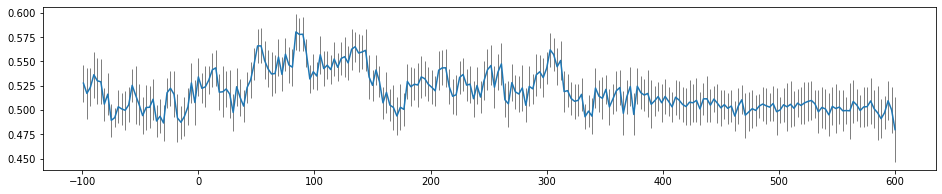

In [66]:
%matplotlib inline
plt.figure(figsize=(16, 3))
# plt.plot(all_times, np.array(acc.T));
plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
plt.savefig(mvpa_fname + '_sigmoid_sd' + '.pdf')
# leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
# leg.get_frame().set_alpha(0.8)

# Debug: Single-_t_ case

In [48]:
all_durs = 4  # [1, 2, 3, 4]
all_conts = 100  # [17, 33, 50, 100]
t = 87
acc_index = pd.MultiIndex.from_product([[all_durs], [all_conts]], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((1, len(all_times))), index=acc_index, columns=all_times)
cur_cond_str = 'dur4/cont100'
epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)].loc[pd.IndexSlice[:, :, t], :]

In [49]:
cur_cond_str

'dur4/cont100'

In [50]:
epochs_subset_df.head

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
left/dur4/cont100  28    87   -0.532187  0.841984 -1.148955  0.347068   
                   73    87    0.001669 -1.914992  0.199287 -1.372988   
                   95    87    0.681560 -0.563295  0.765399  0.715947   
                   126   87   -0.534997 -0.710329 -0.548943 -0.427726   
right/dur4/cont100 4     87   -2.445140 -1.466747 -0.095105 -0.385865   
                   117   87   -2.531146 -4.009911  0.641970 -0.694386   
left/dur4/cont100  7     87    1.870250 -2.667666  1.255343  1.814966   
                   38    87   -0.024609 -2.712332  0.173106  2.121639   
                   66    87    1.155252  2.709733  1.329198  0.045742   
                   113   87   -1.106438 -1.024625  0.159252 -0.779633   
right/dur4/cont100 12    87   -2.004501  1.958746 -0.444742 -0.950506   
                   53    87   -2.467044 -0.818693  0.017781 -1.080679   
                   83    87   -1.424181  0.342090 -0.349939 -0.557083   
                   132   87    0.824744 -0.242949  2.631134 -0.891279   
left/dur4/cont100  12    87   -2.210444  0.320056  1.229156 -1.747855   
                   47    87   -1.010832  0.257486  1.957704 -2.186565   
                   88    87    0.394357  1.370230  1.179309  0.022699   
right/dur4/cont100 37    87    0.079109  1.405480 -0.546451  0.530361   
                   52    87   -2.948062 -0.848601  0.905544 -2.303550   
                   84    87   -1.271143  0.549636 -1.664047 -0.755663   
                   106   87   -1.914742  0.635216 -1.566875  0.919520   
                   127   87    1.415921  0.583599  0.935689 -0.444868   
left/dur4/cont100  15    87    1.317898  1.295244  0.360979  0.344869   
                   45    87   -3.880469 -0.316623  3.647417 -3.564018   
                   113   87    0.260823 -1.572899  2.478096 -1.460877   
                   142   87   -3.560856  1.774840  2.156608 -4.579022   
right/dur4/cont100 31    87    0.202418 -1.521398 -1.176886  1.344007   
                   63    87   -0.599207 -1.022918  0.574462 -0.778426   
                   80    87    3.726225  1.627503  2.110089  3.079816   
                   110   87    1.712681  1.000974 -1.810298  1.104415   
                   136   87    1.066904 -0.494127 -0.198136  1.413971   
left/dur4/cont100  5     87   -4.340701 -0.718488 -1.394131 -1.509782   
                   35    87    0.486956 -1.288249  1.198191 -0.423429   
                   55    87   -1.141342  0.275912 -0.340937 -1.132303   
                   90    87   -0.474998 -0.523845  0.468660  0.052657   
                   101   87    1.094551  0.316671  0.619263  0.253239   
                   131   87   -0.716455 -1.731380  0.884768 -0.875953   
right/dur4/cont100 2     87   -1.306531  2.323043  0.315767 -0.097370   
                   36    87   -4.106647 -0.884964  0.664081 -3.220087   
                   59    87    0.387593  2.287701 -0.246735  0.650511   
                   80    87    0.537135  1.536671  0.851919 -0.278935   
                   138   87   -0.749118  1.272843 -0.329315 -3.089111   
left/dur4/cont100  24    87   -1.304997 -0.398924  1.039750  0.117681   
                   36    87   -0.310838  1.776192 -4.003377  0.858416   
                   66    87    1.566081  0.326238  1.802500 -2.294901   
right/dur4/cont100 8     87   -0.098078 -0.796479  0.241465  0.235240   
                   31    87   -0.888137 -1.919696  1.550200 -3.636018   
                   137   87   -3.251577 -0.072449 -0.397742 -0.919303   
left/dur4/cont100  44    87   -0.294704 -0.676856 -0.505916  0.074826   
                   57    87    3.470133  0.728410  2.962499  1.384745   
                   75    87   -1.578124 -2.540743  2.414194 -2.444233   
                   136   87    1.680099  1.874986  0.745243 -0.027237   
right/dur4/cont100 13    87    0.890129 -0.044995  2.07921

In [51]:
# cur_acc = iter_times(all_times, epochs_subset_df, validate=False)  #, cur_cond_str)
# all_times = np.round(epochs_run.times * 1000).astype(int)
# epochs_subset_df_ = epochs_subset_df
# X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
# X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X_right = epochs_df[epochs_df.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
X_left = epochs_df[epochs_df.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X = np.concatenate((X_right, X_left))
y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))

In [52]:
X

array([[-1.02365007, -1.55588675,  0.97907058, ...,  0.95425321,
        -1.81877869,  0.31250099],
       [-0.65719249, -1.8822684 ,  0.09203422, ..., -0.34739062,
         0.02903462,  0.67668067],
       [-0.02227319,  0.12699574, -0.97254488, ...,  0.79429244,
        -0.30491273, -1.65491967],
       ...,
       [ 3.47013345,  0.7284099 ,  2.96249864, ..., -2.3010024 ,
        -3.85794519, -0.14223711],
       [-1.57812382, -2.54074348,  2.41419373, ...,  2.40113169,
        -4.18864063,  1.94199472],
       [ 1.68009904,  1.87498637,  0.74524303, ...,  2.68492384,
        -2.30447801, -2.37801348]])

In [53]:
np.shape(X)

(1007, 306)

In [54]:
y

array([1, 1, 1, ..., 0, 0, 0])

## New pipeline

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
# clf = svm.SVC(kernel='sigmoid')
# scores = cross_val_score(clf, X, y, cv=4)

In [57]:
# scores

In [58]:
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [62]:
acc_list = []
ss = ShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in ss.split(X):
#     print("%s %s" % (train_index, test_index))
#     print("%s %s" % (len(train_index), len(test_index)))
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    clf = svm.SVC(kernel='sigmoid', gamma=0.001, cache_size=2000).fit(X_train, y_train)
#     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
#     scores = cross_val_score(clf, X_train, y_train, cv=4)
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    y_pred = clf.predict(X_test)
#     print(classification_report(y_test, y_pred))
    this_acc = accuracy_score(y_test, y_pred)
    acc_list.append(this_acc)
#     print(accuracy_score(y_test, y_pred))
print(np.mean(acc_list))

0.6237623762376238


In [63]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 2000,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'sigmoid',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [43]:
np.mean(acc_list)

0.5042857142857143

## Old pipeline

In [45]:
# acc_.append(run_svm(X, y))
cur_test_epoch = 0
X_ = X
y_ = y
preds = []
test_epoch = [X_[cur_test_epoch, :]]
print(test_epoch)
test_class = y_[cur_test_epoch]
print(test_class)
train_epochs = X_[np.arange(len(y_))!=cur_test_epoch, :]
print(train_epochs)
train_classes = y_[np.arange(len(y_))!=cur_test_epoch]
print(train_classes)
clf = svm.SVC()
clf.fit(train_epochs, train_classes)
# preds.append(clf.predict(test_epoch).item(0))
# tests.append(test_class)
# this_pred = clf.predict(test_epoch).item()
this_pred = clf.decision_function(test_epoch)
print('class = ' + str(test_class) + ' prediction = ' + str(this_pred))
iter_acc = sum(np.array(test_class) == np.array(preds)) / len(y_)
preds.append(this_pred)
#     iter_acc = sum(y_ == np.array(preds)) / len(y_)
# iter_acc = sum(np.array(test_class) == np.array(preds)) / len(y_)
#     print(iter_acc)
# print(cur_acc)
# acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

[array([-0.36956135,  0.73309373,  1.06787516, -0.75755323,  0.08489705,
        1.55960791,  0.00894992, -1.04439436,  2.36432964,  0.45551303,
        2.27344104, -0.32096662,  0.23060278,  2.52360691, -0.26085406,
        0.17762013, -0.26240576,  2.15601738,  1.9477414 ,  0.88227018,
        1.02098076,  2.71235764,  0.92814475, -0.41382401, -2.45589901,
        0.89171529,  1.32924547, -1.65028386, -0.90764129,  4.32961109,
       -1.46350941,  3.95418019, -1.16465851, -1.10256051,  4.34931479,
        0.10169362, -0.06588309,  1.1348421 ,  0.30331055, -0.00723888,
       -1.48845733,  0.87922055,  0.41411137, -2.61283308,  1.08089786,
        0.31051695,  0.82107578,  0.6177865 , -2.98149601, -0.86486361,
        1.69392695, -2.59793124, -2.70112497,  1.40536888, -3.19943117,
       -0.10398802, -2.53076745, -3.38371282, -1.40825588, -0.0995284 ,
       -2.51236648, -0.60546487, -1.67164513, -0.93175466, -3.39756426,
       -1.13540022,  0.41402291, -0.71647768, -1.54760779, -1.1

In [112]:
preds = []
tests = []
for cur_test_epoch in range(len(y_)):
    test_epoch = [X_[cur_test_epoch, :]]
    test_class = y_[cur_test_epoch]
    train_epochs = X_[np.arange(len(y_))!=cur_test_epoch, :]
    train_classes = y_[np.arange(len(y_))!=cur_test_epoch]
    clf = svm.SVC(kernel='poly')  # kernel='linear':43% vs. kernel='poly':41%
    clf.fit(train_epochs, train_classes)
#     preds.append(clf.predict(test_epoch).item(0))
    tests.append(test_class)
    this_pred = clf.predict(test_epoch).item()
#     this_pred = clf.decision_function(test_epoch)
    print('class = ' + str(test_class) + ' prediction = ' + str(this_pred))
    preds.append(this_pred)
#     iter_acc = sum(y_ == np.array(preds)) / len(y_)
print(sum(np.array(tests) == np.array(preds)) / len(y_))
#     print(iter_acc)

class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 1
class = 1 prediction = 0
class = 1 prediction = 1
class = 1 prediction = 1
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 1 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 1
class = 0 prediction = 1
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 0
class = 0 prediction = 1


# Debug: Single-condition poly

## Validation

In [115]:
all_durs = [4]  # [1, 2, 3, 4]
all_conts = [100]  # [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))),
                   index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
        cur_acc = iter_times(all_times, epochs_subset_df, validate=True)  #, cur_cond_str)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

dur4/cont100 [==========]


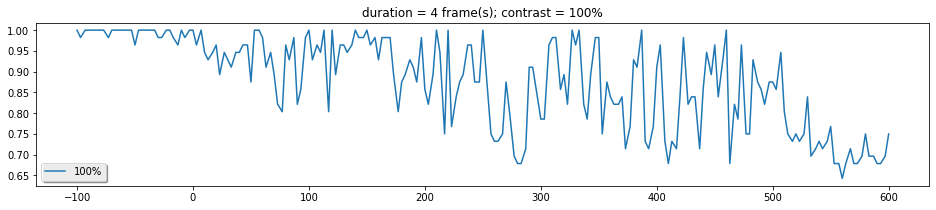

In [116]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

## Training

In [120]:
all_durs = [4]  # [1, 2, 3, 4]
all_conts = [100]  # [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))),
                   index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)]
        cur_acc = iter_times(all_times, epochs_subset_df, validate=False)  #, cur_cond_str)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc

dur4/cont100 [==========]


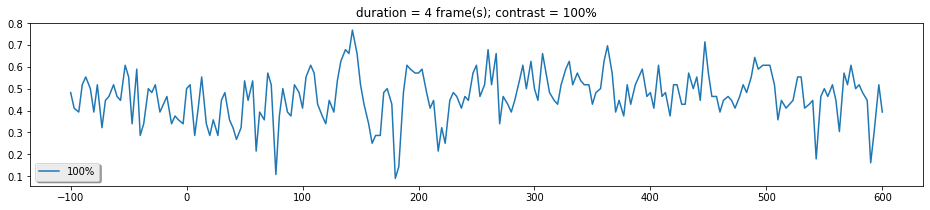

In [121]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)